# COVID19 - RISK FACTORS ANALYSIS


## CONTENTS

### (1) DATA CLEANING.........................................................................................................................................
### (2) MODEL SELECTION AND FITTING TO DATA............................................................................................
### (3) DATA VISUALIZATION AND EXPLORATORY DATA ANALYSIS...............................................................
### (4) DERIVING INSIGHTS FROM MODEL'S RESULTS.....................................................................................



In [1]:
# IMPORTING ALL REQUIRED LIBRARIES AND FUNCTIONS..............................................................

import csv
import random
import numpy as np
import pandas as pd
from collections import Counter
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.feature_extraction.text import CountVectorizer , TfidfTransformer
import pickle
import os 
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer


# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.manifold import TSNE
!pip install bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
from sklearn.cluster import AgglomerativeClustering 

# Machine Learning
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as sch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import gensim
from gensim import corpora , models
from collections import Counter
import gensim,logging, warnings
warnings.filterwarnings("ignore")
!pip install pyLDAvis
from gensim.models import ldamodel
import pyLDAvis
import pyLDAvis.sklearn
from pyLDAvis import sklearn as sklearn_lda


%matplotlib inline

In [2]:
#Calling metadata csv file
df = pd.read_csv('metadata.csv')
df.info(verbose=True)
df.head(3) # displaying first 3 rows of the dataframe 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45774 entries, 0 to 45773
Data columns (total 17 columns):
cord_uid                       45774 non-null object
sha                            31753 non-null object
source_x                       45774 non-null object
title                          45617 non-null object
doi                            42440 non-null object
pmcid                          26243 non-null object
pubmed_id                      34641 non-null float64
license                        45774 non-null object
abstract                       37913 non-null object
publish_time                   45765 non-null object
authors                        43774 non-null object
journal                        41707 non-null object
Microsoft Academic Paper ID    964 non-null float64
WHO #Covidence                 1768 non-null object
has_full_text                  45774 non-null bool
full_text_file                 35558 non-null object
url                            45472 non-null 

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,url
0,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/001727
1,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/003889
2,62gfisc6,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,biorxiv,Sequencing of the human IG light chain loci fr...,10.1101/006866,NaN,NaN,biorxiv,Germline variation at immunoglobulin gene (IG)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/006866


## (1) DATA CLEANING________________________________________________________________________

In [3]:
# load the meta data from the CSV file 
df=pd.read_csv('metadata.csv', usecols=['title','abstract','authors','doi','publish_time']) # using only necessary columns
print (df.shape)

#dropping duplicates
df = df.drop_duplicates(subset='abstract', keep="first")

#dropping NANs 
df=df.dropna()
df.reset_index(drop=True, inplace = True)

# converting abstracts to lowercase
df["abstract"] = df["abstract"].str.lower()


print (df.shape) # shape of the cleaned dataframe

(45774, 5)
(34809, 5)


In [4]:
df['abstract'].head(1)

0    next-generation sequencing is increasingly bei...
Name: abstract, dtype: object

### MAKING A LIST OF RISKS FACTORS FOR COVID19 DATA ANALYSIS

In [5]:
risk_factors = ['immunity','healthy','adult','morbidity',
                'stress','neonates','perinatal','asthma','diabetes','lung disease',
                'heart disease','pregnancy','old age','infant',
                'smoking','cardiovascular',
                'cancer']

In [6]:
risks = []                                   # Making an empty list to to append keywords from the abstracts
for risk in risk_factors:
    for abstract in df['abstract']:          # searching keywords from risk_factors list from the abstracts
        if str(risk) in abstract:
            risks.append(risk)           
    

In [7]:
# converting a list into dictionary having keywords as keys and its count as values
risk_dict = dict(Counter(risks))
print(risk_dict)

{'immunity': 1817, 'healthy': 1112, 'adult': 1522, 'morbidity': 1226, 'stress': 1237, 'neonates': 107, 'perinatal': 51, 'asthma': 446, 'diabetes': 280, 'lung disease': 196, 'heart disease': 92, 'pregnancy': 187, 'old age': 30, 'infant': 650, 'smoking': 115, 'cardiovascular': 234, 'cancer': 1095}


### DATA VISUALIZATION OF NUMBER OF RESEARCH PAPERS WITH KEYWORDS

### PLOT 1: BAR GRAPH OF  COUNTS OF RESEARCH PAPERS WITH KEYWORDS
From the below bar graph, we can say that the number of research papers with "immunity" keyword is the highest. The second highest keyword which is mentioned in the research papers is "adult". Adults are less susceptible to COVID19 as their immune system is strong compared to older people. The first highest keyword "immunity" has also a vital role not only in COVID19 but in any type of disease. The least appeared word is " old age".

Text(0, 0.5, 'Research- Paper counts')

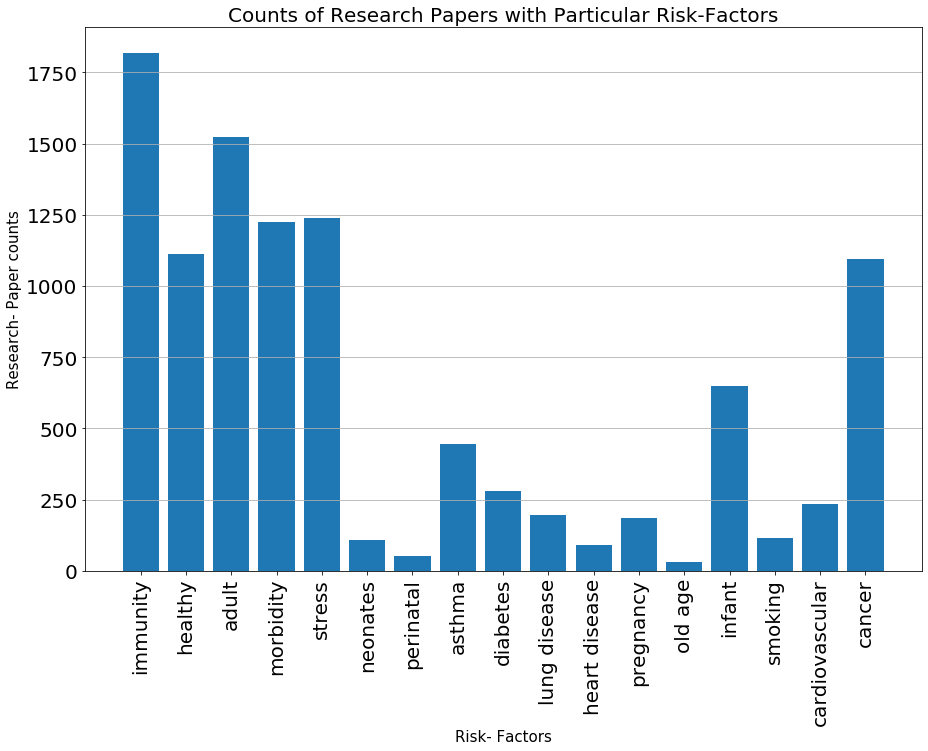

In [8]:
# plotting a bar graph of the counts of research papers in which particular keyword is mentioned 
keys = risk_dict.keys()
values = risk_dict.values()
plt.figure(figsize=(15,10))
plt.bar(keys,values)
plt.grid(axis = "y")
plt.xticks(size = 20 , rotation = 90)
plt.yticks(size = 20)
plt.title("Counts of Research Papers with Particular Risk-Factors", size = 20)
plt.xlabel("Risk- Factors", size = 15)
plt.ylabel("Research- Paper counts", size = 15)

## (2) MODEL SELECTION AND FITTING TO DATA____________________________________________________

We will explore 4 different approaches in this section. 

- 1) Hierarchical clustering using research papers' counts to formulate distance matrix
- 2) LDA (Latent Dirichlet Allocation) using Sklearn library
- 3) LDA (Latent Dirichlet Allocation) using GenSIm model
- 4) Hierarchical clustering using TF-IDF to formulate distance matrix (with euclidean and cosine metric)

### 1) HIERARCHICAL CLUSTERING USING RESEARCH PAPER'S COUNTS TO FORMULATE DISTANCE MATRIX


To compute the distance matrix, I used the counts of research papers with keywords. Using the euclidean distance function, I formulated 18 * 18 distance matrix. With the help of this matrix, I will plot hierarchical clustering using centroid as a method. This method directly shows the relation between the importance of keywords as we are considering how many research paper it is being appeared.

In [9]:
# converting dictionary into dataframe
risk_dict1 = pd.DataFrame(risk_dict.values(), index = risk_dict.keys())

In [10]:
# calculating distance matrix using pdist function 
risk_matrix = pd.DataFrame(
    squareform(pdist(risk_dict1)),
    columns = risk_dict1.index,
    index = risk_dict1.index
)

In [11]:
risk_matrix.shape # shape of distance matrix 

(17, 17)

In [12]:
# normalising distance matrix by dividing each value with total number of abstracts
risk_matrix = risk_matrix/len(df.abstract)
risk_matrix.head()

,immunity,healthy,adult,morbidity,stress,neonates,perinatal,asthma,diabetes,lung disease,heart disease,pregnancy,old age,infant,smoking,cardiovascular,cancer
immunity,0.000000,0.020253,0.008475,0.016978,0.016662,0.049125,0.050734,0.039386,0.044155,0.046568,0.049556,0.046827,0.051337,0.033526,0.048895,0.045477,0.020742
healthy,0.020253,0.000000,0.011779,0.003275,0.003591,0.028872,0.030481,0.019133,0.023902,0.026315,0.029303,0.026574,0.031084,0.013272,0.028642,0.025223,0.000488
adult,0.008475,0.011779,0.000000,0.008504,0.008188,0.040650,0.042259,0.030912,0.035680,0.038094,0.041081,0.038352,0.042862,0.025051,0.040421,0.037002,0.012267
morbidity,0.016978,0.003275,0.008504,0.000000,0.000316,0.032147,0.033756,0.022408,0.027177,0.029590,0.032578,0.029849,0.034359,0.016547,0.031917,0.028498,0.003763
stress,0.016662,0.003591,0.008188,0.000316,0.000000,0.032463,0.034072,0.022724,0.027493,0.029906,0.032894,0.030165,0.034675,0.016863,0.032233,0.028814,0.004079


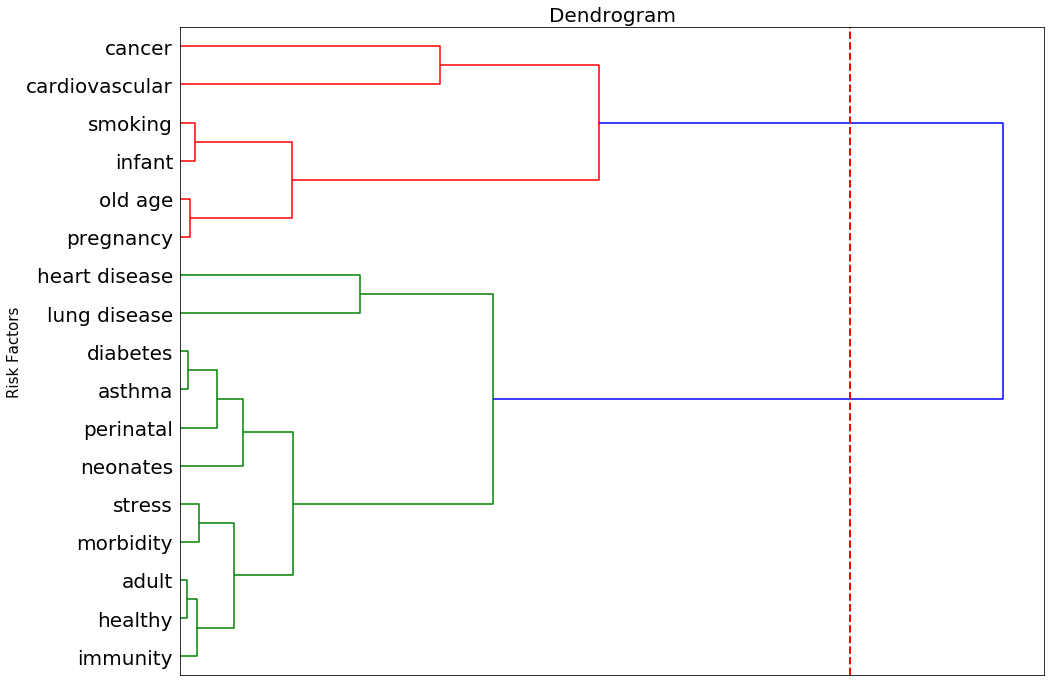

In [13]:
#Hierarchical Clustering

H = sch.linkage(risk_matrix.values, 'centroid')   # fitting the distance matrix 
labels=risk_matrix.index

fig = plt.figure(figsize=(30,15))
ax = fig.add_axes([0.1,0.1,0.4,0.6])

H1 = sch.dendrogram(H, orientation='right',p=25)  #plotting dendrogram
sch.set_link_color_palette(['c', 'm', 'y', 'k'])

ax.set_xticks([])
ax.set_yticklabels(labels, fontsize=20)

plt.title("Dendrogram", size = 20)
plt.ylabel("Risk Factors", size=15)
plt.axvline(x=100, color='r', linestyle='--')
plt.axvline(x=0.09, c='r', lw=2, linestyle='dashed')
plt.tight_layout()


**NOT SO GOOD RESULT**

#### As we can see that, this result is not up to the mark. Some of the keywords with less risk factors are merging with high risk keywords. (i.e. adult, healthy. immunity words which have less possibility of fatality are coming into the cluster which has other high risk factors like morbidity, stress, perinatal, heart disease and lung disease). We will explore more with other unsupervised machine learning models. 

### 2) LATENT DIRICHLET ALLOCATION (LDA) TOPIC MODELING FROM SKLEARN LIBRARY

LDA is a model of unsupervised machine learning. In LDA it forms hidden layers of topics based on the common subject of the documents and based on the probability of words coming into a particular topic, it distributes the words into topics. These hidden layers are called "Latent". It builds a topic per document and a word per document. Thus the name "Dirichlet Allocation". 

In [14]:
###################################################################################################################################################
# making a copy of dataframe for future tf-idf usage as after tokenization abstract column converts into list. tf-idf will not recognize the list.#
###################################################################################################################################################
df_for_tf = df.copy()

In [15]:
# counting tf score with tfidf vectorizer.
 
vectorizer = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word',stop_words="english", 
                            ngram_range=(1, 1), max_df=0.9, min_df=1, max_features=10000, vocabulary = risk_factors, use_idf = False)

# I am considering only term frequency as it is giving me good results compared to tf-idf. That is why considered "False" for use_idf

tf = vectorizer.fit_transform(df_for_tf.abstract).toarray() # fitting abstract data to get tf scores

In [16]:
a = vectorizer.get_feature_names() # find features names

In [17]:
# calling LDA model
LDA = LatentDirichletAllocation(n_components=4, random_state=42) # choosing n_components = 5 to get 5 clusters or 5 topics  
LDA.fit(tf) # fitting model to our tf array

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=4, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [18]:
first_risk_cluster = LDA.components_[1]  #probabilities of words coming into first risk cluster

In [19]:
first_risk_cluster #probabilities of words coming into first risk cluster

array([2.52319110e-01, 2.52154125e-01, 2.51452992e-01, 1.33224283e+03,
       2.50697795e-01, 2.51111521e-01, 2.53761978e-01, 2.51144188e-01,
       2.52334196e-01, 2.50000000e-01, 2.50000000e-01, 2.52510850e-01,
       2.50000000e-01, 2.10716833e+02, 2.53852110e-01, 2.53839654e-01,
       1.92324564e+03])

In [20]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 4 words for risk factor cluster #{i+1}:')                     #################################################################
    print([vectorizer .get_feature_names()[i] for i in topic.argsort()[-4:]]) # getting first 3 words which have high probability for coming###
                                                                              ####################### into that topic/cluster##################
    print('\n')                                                               #################################################################

Top 4 words for risk factor cluster #1:
['infant', 'perinatal', 'neonates', 'stress']


Top 4 words for risk factor cluster #2:
['smoking', 'infant', 'morbidity', 'cancer']


Top 4 words for risk factor cluster #3:
['cardiovascular', 'pregnancy', 'asthma', 'immunity']


Top 4 words for risk factor cluster #4:
['smoking', 'diabetes', 'adult', 'healthy']




**These results are better than the results of hierarchical clustering using a distance matrix of research paper counts.**

Let's discuss each cluster.

**Top 4 words for risk factor cluster #1:
['infant', 'perinatal', 'neonates', 'stress']**
- In the first cluster or topic, the probability of the keyword "stress" is highest whereas "neonates", " perinatal" and "infant" have second, third and fourth highest probability for coming into the first topic. Stress/hypertension patients have a high risk of severe illness, Neonates ( age : less than 28 days old) do not have an immunity system, the chances of getting an infection is very high at this stage. In perinatal duration, mother's immune system is also weak. The immunity system in infants is of mother's immunity system, they have not started developing their own immunity system. Patients with one of these conditions have high chances of severe illness and all these keywords are related to pregnancy and newborn babies. Thus, this cluster can be considered as "High Risk Maternal Keyword".
 
**Top 4 words for risk factor cluster #2:
['smoking', 'infant', 'morbidity', 'cancer']**
 - In the second cluster, all four words have high chances of turning into severe illness due to COVID19. Cancer patients immune system has already been weaken by the chemotherapy, Patients with morbidity( patient who has one or more than one existing disease) are also prone to severe illness and Smoking causes lungs injuries and patients with smoking addiction are prone to severe illness as COVID19 directly damages respiratory system. This could also turn into a fatality. So this cluster can be considered as "High and Moderate Level Risk due to Disease Keywords cluster".
 
**Top 4 words for risk factor cluster #3:
['cardiovascular', 'pregnancy', 'asthma', 'immunity']**
- In the third cluster, we are getting some mix words. A person with low immunity has a high risk of getting COVID19. A patient with asthma has high chance of severe illness. During pregnancy, mothers are susceptible to infection and patient with cardiovascular disease has a high probability of turning the illness into a fatality. So considering the keywords, this cluster can be derived as " High  level Disease Risk Keywords cluster"
 
**Top 4 words for risk factor cluster #4:
['smoking', 'diabetes', 'adult', 'healthy']**
- In the last cluster, all four words are related to adult issues. First word "healthy" can be considered in the context of adults. As adults have a good immune system compared to infants and old age people. They have a high possibility of getting cured in COVID19. Patients with diabetes, are also susceptible to COVID19 and smoking is already considered in the second cluster and adults are more addicted to smoking. So this cluster can be considered as " Adult's related Risk Keywords".
 
**We can classify the results of LDA(Sklearn) into 4 different clusters:**
 - 1) High Risk Maternal Keyword cluster
 - 2) High and Moderate Level Risk due to Disease Keywords cluster
 - 3) High  level Disease Risk Keywords cluster
 - 4) Adult's related Risk Keywords clsuetr


### 3) LATENT DIRICHLET ALLOCATION (LDA) TOPIC MODELING USING GENSIM.MODEL

**For LDA modeling with GenSim models, more clean data is required.**

- CLEANING THE DATA FOR FURTHER DATA ANALYSIS WITH GENSIM.MODEL

In [21]:
#defin a function to remove punctuation from text
def remove_punct(text):
    punct = "".join([i for i in text if i not in string.punctuation])
    return punct

In [22]:
df['abstract'] = df['abstract'].apply(lambda x : remove_punct(x)) #cleaning all punctuations from the abstracts
df['abstract'].head(1)

0    nextgeneration sequencing is increasingly bein...
Name: abstract, dtype: object

In [23]:
# use regular expression tokenizer to tokenize the abstracts 
tokenizer = RegexpTokenizer(r'\w+')

In [24]:
df['abstract'] = df['abstract'].apply(lambda x : tokenizer.tokenize(x))

In [25]:
clean_abs = df['abstract'] # changing the name of abstract column

In [26]:
# splitting the factors in risk_factors list for further analysis
factors = [risk.split() for risk in risk_factors]

In [27]:
factors

[['immunity'],
 ['healthy'],
 ['adult'],
 ['morbidity'],
 ['stress'],
 ['neonates'],
 ['perinatal'],
 ['asthma'],
 ['diabetes'],
 ['lung', 'disease'],
 ['heart', 'disease'],
 ['pregnancy'],
 ['old', 'age'],
 ['infant'],
 ['smoking'],
 ['cardiovascular'],
 ['cancer']]

In [28]:
# creating dictionary of the relevant keywords
id2word = corpora.Dictionary(factors)

In [29]:
# creating corpus with term document frequency of the abstracts
corpus = [id2word.doc2bow(text) for text in clean_abs]

In [30]:
# finding tf_idf scores with corpus
tfidf = models.TfidfModel(corpus)
tf_corpus = tfidf[corpus]

In [31]:
# calling LDA model
LDA_gen = gensim.models.ldamodel.LdaModel(corpus=tf_corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=3,
                                           passes=3,
                                           alpha='symmetric',
                                           iterations=100,
                                      
                                           per_word_topics=True)

In [32]:
print(LDA_gen.print_topics(num_words=3)) # printing top keywords in top topics

[(0, '0.616*"age" + 0.370*"morbidity" + 0.012*"infant"'), (1, '0.614*"immunity" + 0.121*"heart" + 0.102*"cardiovascular"'), (2, '1.000*"disease" + 0.000*"smoking" + 0.000*"heart"'), (3, '0.347*"stress" + 0.298*"cancer" + 0.158*"adult"'), (4, '0.630*"lung" + 0.205*"asthma" + 0.163*"healthy"')]


## (3) DATA VISUALIZATION AND EXPLORATORY DATA ANALYSIS____________________________________

### PLOT 2: TOPICS CLUSTERING IN 2-D USING PYLDAVIS
I used pyLDAvis to visualize 5 different clusters of the topics resulted from LDA GenSim model.

In [33]:
from pyLDAvis import gensim
pyLDAvis.enable_notebook()

In [34]:
titles = pyLDAvis.gensim.prepare(LDA_gen, tf_corpus, dictionary=LDA_gen.id2word)
titles

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.437370  0.027838       1        1  31.293198
0      0.116452  0.187873       2        1  17.602652
4      0.081552 -0.424386       3        1  17.351841
3      0.117689  0.121317       4        1  17.122877
1      0.121677  0.087358       5        1  16.629433, topic_info=   Category         Freq            Term        Total  loglift  logprob
9   Default  5553.000000         disease  5553.000000  19.0000  19.0000
10  Default  1942.000000            lung  1942.000000  18.0000  18.0000
13  Default  1925.000000             age  1925.000000  17.0000  17.0000
0   Default  1813.000000        immunity  1813.000000  16.0000  16.0000
3   Default  1158.000000       morbidity  1158.000000  15.0000  15.0000
4   Default  1055.000000          stress  1055.000000  14.0000  14.0000
18  Default   907.000000          cancer   907.000000  13.0000  13.0000
7   Default   632.000000          asthma   632.000000  12.0000  12.0000
1   Default   504.000000         healthy   504.000000  11.0000  11.0000
2   Default   480.000000           adult   480.000000  10.0000  10.0000
11  Default   358.000000           heart   358.000000   9.0000   9.0000
14  Default   315.000000             old   315.000000   8.0000   8.0000
17  Default   301.000000  cardiovascular   301.000000   7.0000   7.0000
16  Default   281.000000         smoking   281.000000   6.0000   6.0000
8   Default   166.000000        diabetes   166.000000   5.0000   5.0000
5   Default   121.000000        neonates   121.000000   4.0000   4.0000
6   Default    97.000000       perinatal    97.000000   3.0000   3.0000
12  Default    96.000000       pregnancy    96.000000   2.0000   2.0000
15  Default    39.000000          infant    39.000000   1.0000   1.0000
9    Topic1  5552.894531         disease  5553.894043   1.1616  -0.0005
15   Topic1     0.150152          infant    39.236107  -4.4039 -10.5187
12   Topic1     0.150381       pregnancy    96.351997  -5.3008 -10.5171
6    Topic1     0.150211       perinatal    97.123383  -5.3099 -10.5183
5    Topic1     0.150213        neonates   121.604980  -5.5347 -10.5183
8    Topic1     0.150209        diabetes   166.704926  -5.8502 -10.5183
16   Topic1     0.150479         smoking   281.863586  -6.3736 -10.5165
17   Topic1     0.150445  cardiovascular   301.647583  -6.4416 -10.5167
14   Topic1     0.150172             old   315.314911  -6.4878 -10.5185
11   Topic1     0.150464           heart   358.010284  -6.6128 -10.5166
2    Topic1     0.150239           adult   480.568146  -6.9087 -10.5181
..      ...          ...             ...          ...      ...      ...
5    Topic4     0.240734        neonates   121.604980  -4.4601  -9.4436
8    Topic4     0.241022        diabetes   166.704926  -4.7743  -9.4424
17   Topic4     0.240588  cardiovascular   301.647583  -5.3692  -9.4442
11   Topic4     0.240573           heart   358.010284  -5.5405  -9.4443
1    Topic4     0.242596         healthy   504.556580  -5.8753  -9.4359
7    Topic4     0.240691          asthma   632.934875  -6.1099  -9.4438
3    Topic4     0.241401       morbidity  1158.162964  -6.7111  -9.4409
0    Topic4     0.241034        immunity  1813.650879  -7.1612  -9.4424
13   Topic4     0.241845             age  1925.586792  -7.2177  -9.4390
10   Topic4     0.242225            lung  1942.917725  -7.2251  -9.4375
9    Topic4     0.245777         disease  5553.894043  -8.2608  -9.4229
0    Topic5  1812.785400        immunity  1813.650879   1.7935  -0.4877
11   Topic5   357.144684           heart   358.010284   1.7916  -2.1122
17   Topic5   300.781403  cardiovascular   301.647583   1.7911  -2.2840
8    Topic5   165.839203        diabetes   166.704926   1.7888  -2.8793
5    Topic5   120.736580        neonates   121.604980   1.7868  -3.1967
6    Topic5    96.255310       perinatal    97.123383   1.7850  -3.4233
12   Topic5    95.487473       pregnancy    96.3519

 As I need to clean the data to fit the keywords into a dictionary, I need to tokenize it. This process has separataed lung and heart words from disease word. So this model has considered disease word individually not as a bigram with lung and heart. The same has happened with "old age". Two words are separately considered in the analysis. 

**Classification of Clusters**

- In the first cluster, the probability of "disease" word is 100%. So this cluster has only one word "disease". We can consider this as "General Disease Risk Keyword" cluster.

- Age, Morbidity and Infant words appeared into the second cluster. There is no proper relation between keywords as age is from the "old age". We can classify it as "Age Related Risk keywords" cluster.

- In the third cluster, Lung has the highest probability of being in that topic following by Asthma and Healthy. Except "healthy", "lung" and "asthma" words are correlated. We can classify this cluster as "Lung Disease Related High Risk Keywords" cluster.

- In the fourth cluster, there are 5 keywords. Stress, cancer, adult, old and smoking. These keywords are correlated in terms of age. As "stress" and "Smoking" is more prevalent in adults and old age people. We can classify as "Adult Related High Risk Keywords" cluster.

- The fifth cluster has all high risk keywords, which could turn into fatality if a patient has any of the conditions. Heart related problems, cardiovascular( which is also heart related and we are getting heart and cardiovascular in the same cluster),low immunity, diabetes, neonates, perinatal, pregnancy, all these keywords may turn patients condition into severe illness if caught by COVID19. So this cluster can be classified as "Fatality Risk Keywords" cluster.

**So we can classify results of LDA(GenSim Model) into 5 different clusters**

- 1) "General Disease Risk Keyword" cluster
- 2) "Age Related Risk keywords" cluster
- 3) "Lung Disease Related High Risk Keywords" cluster
- 4) "Adult Related High Risk Keywords" cluster
- 5) "Fatality Risk Keywords" cluster

#### Both LDA models are giving us good results. With the help of both models' results, we are able to classify different clusters based on the risk factors. 

### PLOT 3: BAR GRAPH OF PROBABILITIES OF KEYWORDS COMING INTO DIFFERENT CLUSTERS

As we can see that each word has a different probability of importance in different topics. "Disease" word has 100% probability and thus the highest importance of coming into cluster 3 however "immunity" and "age" have the same (60%) probability of coming into their respective clusters. "infant" with the least probability (0.012%) comes into the first cluster.

The sequence of cluster numbers has been changed as "Top Topics" can be decided with the highest probability of the keywords coming into a particular cluster. So pyLDAvis has considered risk cluster 3 as its first topic/cluster as "disease" word has 100% probability of considering into that cluster. Likewise, each and every cluster are decided with the importance/probability of the keywords.

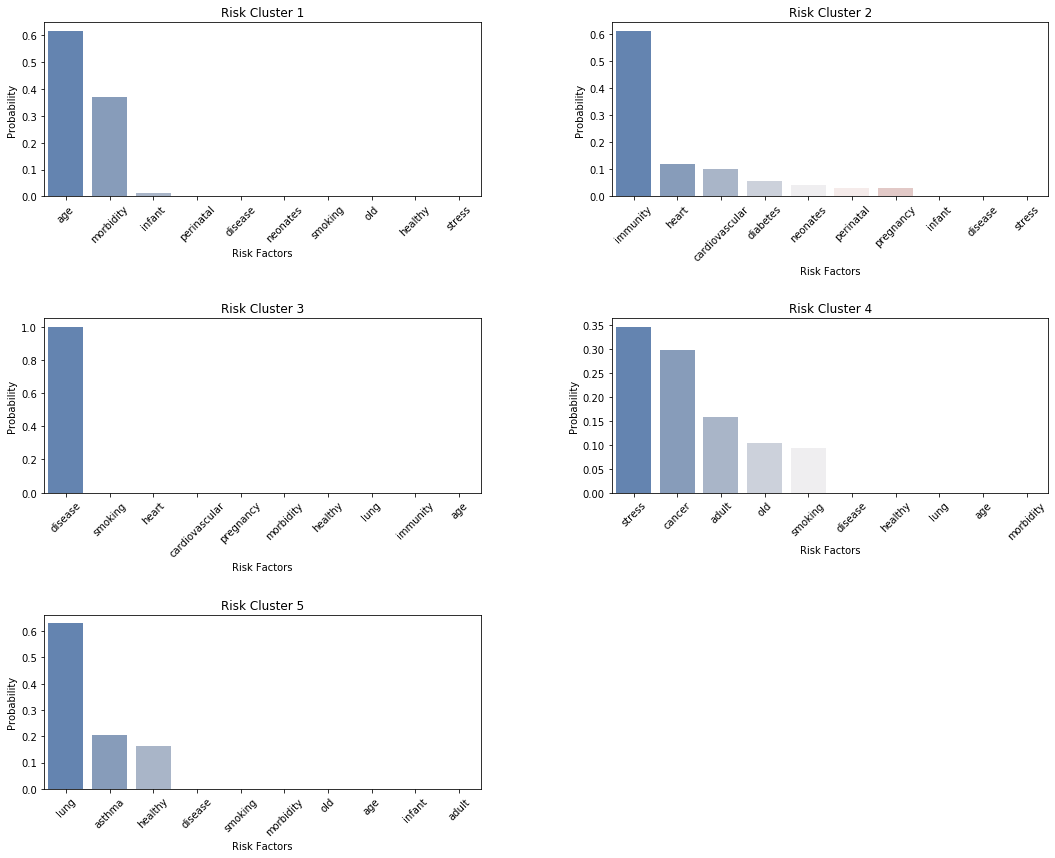

In [35]:
fig=plt.figure(figsize=(18,25))
for i in range(5):
    topic_df=pd.DataFrame(LDA_gen.show_topic(i), columns=['Risk','Probability']).set_index('Risk')
    plt.subplot(5,2,i+1)
    plt.title('Risk Cluster '+str(i+1))
    sns.barplot(x=topic_df.index, y='Probability', data=topic_df, palette='vlag')
    plt.xlabel('Risk Factors')
    plt.xticks(rotation=45)
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.7)
plt.show()

### PLOT 4: T-SNE PLOT OF MULTIDIMENSIONAL TOPICS

With the help of T-SNE plot, we can visualize multidimesional 5 topics or clusters into 2D.

In [36]:
# Fetching topic weights
topic_w = []
for i, row in enumerate(LDA_gen[tf_corpus]):
    topic_w.append([w for i, w in row[0]])

In [37]:
# Finding top topics

# Array of topic weights    
weights = pd.DataFrame(topic_w).fillna(0).values

# Keep the well separated points (optional)
weights = weights[np.amax(weights, axis=1) > 0.35]

# Top topic number in each doc
topic_num = np.argmax(weights, axis=1)

# tSNE Dimension Reduction
tsne= TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne.fit_transform(weights)

# Plot the Topic Clusters using Bokeh
output_notebook()

mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(5), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15608 samples in 0.056s...
[t-SNE] Computed neighbors for 15608 samples in 0.711s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15608
[t-SNE] Computed conditional probabilities for sample 2000 / 15608
[t-SNE] Computed conditional probabilities for sample 3000 / 15608
[t-SNE] Computed conditional probabilities for sample 4000 / 15608
[t-SNE] Computed conditional probabilities for sample 5000 / 15608
[t-SNE] Computed conditional probabilities for sample 6000 / 15608
[t-SNE] Computed conditional probabilities for sample 7000 / 15608
[t-SNE] Computed conditional probabilities for sample 8000 / 15608
[t-SNE] Computed conditional probabilities for sample 9000 / 15608
[t-SNE] Computed conditional probabilities for sample 10000 / 15608
[t-SNE] Computed conditional probabilities for sample 11000 / 15608
[t-SNE] Computed conditional probabilities for sample 12000 / 15608
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

### 4) HIERARCHICAL CLUSTERING USING TF-IDF TO FORMULATE DISTANCE MATRIX(WITH EUCLIDEAN AND COSINE METRIC)

In this method, I am going to use tf scores given by tf_idfvectorizer. I will take the sum of all the scores row-wise and use that cumulative scores to compute distance matrix. 

In [38]:
# Converting tf array into dataframe
tf_df = pd.DataFrame(np.round(tf,2), columns = a)

In [39]:
# calculating sum of tf scores row wise
tf_df.sum(axis=0)

immunity          2518.0
healthy           1568.0
adult             1187.0
morbidity         1332.0
stress            1459.0
neonates           174.0
perinatal           72.0
asthma            1548.0
diabetes           488.0
lung disease         0.0
heart disease        0.0
pregnancy          388.0
old age              0.0
infant             215.0
smoking            227.0
cardiovascular     352.0
cancer            1923.0
dtype: float64

In [40]:
# converting this summation of scores for each keywords into dataframe
risk_dict2 = pd.DataFrame(tf_df.sum(axis=0), index = tf_df.columns)

In [41]:
# dataframe of scores
risk_dict2

,0
immunity,2518.0
healthy,1568.0
adult,1187.0
morbidity,1332.0
stress,1459.0
neonates,174.0
perinatal,72.0
asthma,1548.0
diabetes,488.0
lung disease,0.0


In [42]:
# converting these tf scores into distance matrix 
risk_matrix1 = pd.DataFrame(
    squareform(pdist(risk_dict2)),
    columns = risk_dict2.index,
    index = risk_dict2.index
)

In [43]:
# distance matrix
risk_matrix1.head()

,immunity,healthy,adult,morbidity,stress,neonates,perinatal,asthma,diabetes,lung disease,heart disease,pregnancy,old age,infant,smoking,cardiovascular,cancer
immunity,0.0,950.0,1331.0,1186.0,1059.0,2344.0,2446.0,970.0,2030.0,2518.0,2518.0,2130.0,2518.0,2303.0,2291.0,2166.0,595.0
healthy,950.0,0.0,381.0,236.0,109.0,1394.0,1496.0,20.0,1080.0,1568.0,1568.0,1180.0,1568.0,1353.0,1341.0,1216.0,355.0
adult,1331.0,381.0,0.0,145.0,272.0,1013.0,1115.0,361.0,699.0,1187.0,1187.0,799.0,1187.0,972.0,960.0,835.0,736.0
morbidity,1186.0,236.0,145.0,0.0,127.0,1158.0,1260.0,216.0,844.0,1332.0,1332.0,944.0,1332.0,1117.0,1105.0,980.0,591.0
stress,1059.0,109.0,272.0,127.0,0.0,1285.0,1387.0,89.0,971.0,1459.0,1459.0,1071.0,1459.0,1244.0,1232.0,1107.0,464.0


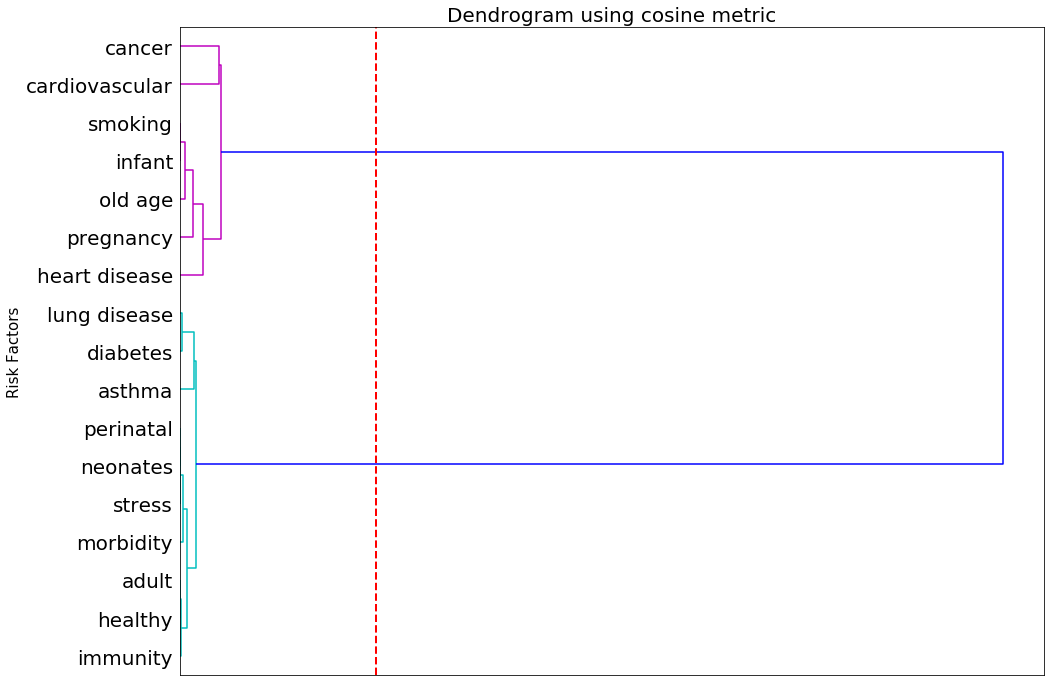

In [44]:
#Hierarchical Clustering using cosine metric

H = sch.linkage(risk_matrix1.values, metric="cosine")
labels=risk_matrix1.index
fig = plt.figure(figsize=(30,15))
ax = fig.add_axes([0.1,0.1,0.4,0.6])
plt.axvline(x=0.08, c='r', lw=2, linestyle='dashed')
H1 = sch.dendrogram(H, orientation='right',  truncate_mode='lastp',p=25)
sch.set_link_color_palette(['c', 'm', 'y', 'k'])
ax.set_xticks([])
ax.set_yticklabels(labels, fontsize=20)
plt.title("Dendrogram using cosine metric", size = 20)
plt.ylabel("Risk Factors", size = 15)
plt.tight_layout()
plt.show()

Hierarchical graph with a cosine metric gives a cluttered result. Cancer, cardiovascular, smoking, infant, old age, pregnancy and heart disease are coming into one cluster whereas lung disease, diabetes, asthma, perinatal, neonates, stress, morbidity, adult, healthy and immunity are coming into the second cluster. 

By logic cosine should give us better results as cosine similarity is used to quantitatively find similarity of documents by measuring cosine angle between two vectors(documents) in multidimensional space irrespective of document size.

The results that we are getting using the cosine metric are not satisfactory which encouraged me to use the centroid method to get clusters. 

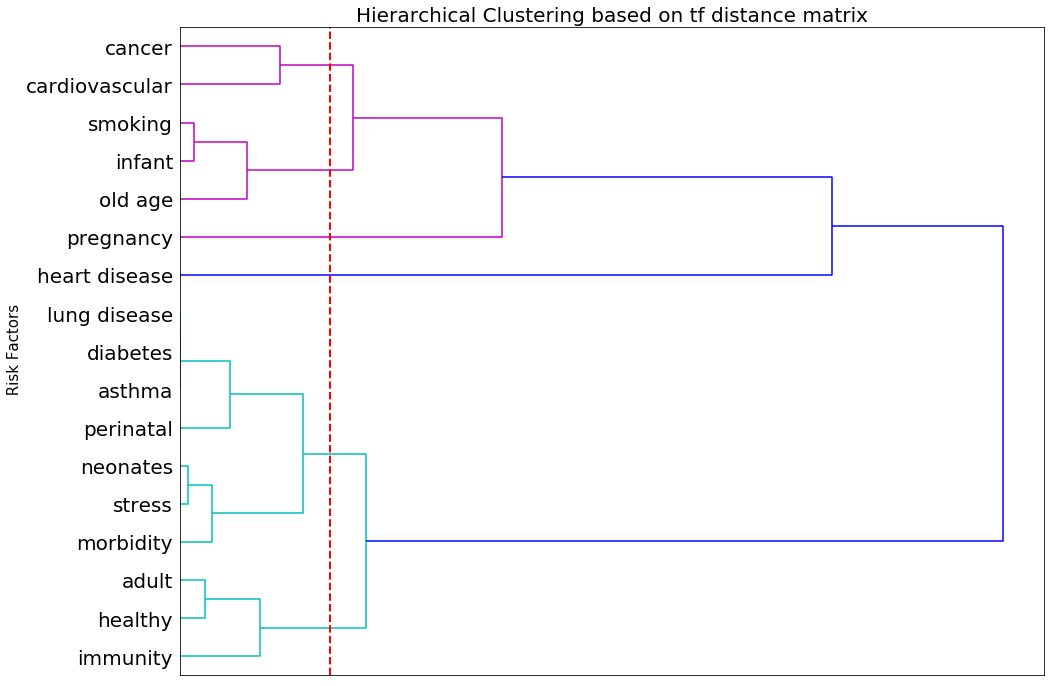

In [45]:
#Hierarchical Clustering using centroid method

H = sch.linkage(risk_matrix1.values, "centroid")
labels=risk_matrix1.index
fig = plt.figure(figsize=(30,15))
ax = fig.add_axes([0.1,0.1,0.4,0.6])
plt.axvline(x=900, c='r', lw=2, linestyle='dashed')
H1 = sch.dendrogram(H, orientation='right',  truncate_mode='lastp',p=25)
sch.set_link_color_palette(['c', 'm', 'y', 'k'])
ax.set_xticks([])
ax.set_yticklabels(labels, fontsize=20)
plt.title("Hierarchical Clustering based on tf distance matrix", size = 20)
plt.ylabel(" Risk Factors" ,  size=15)
plt.tight_layout()
plt.show()

**This result seems perfect**

**Classification of clusters**

- Cancer and cardiovascular are coming in the first cluster. As discussed both are high level risk factors. If a patient has any of the conditions, COVID19 may convert into a fatality. So this can be considered as "Fatal Risk Factors Keywords" cluster.
- Smoking, infant and old age are coming into the second cluster. Except for smoking infant and old age can be classified as age related risk factors. But if we consider the fatality risk, all three can be considered as high level risk factors. This cluster can be considered as "Age Related Risks Keywords" cluster. 
- In the third cluster, there is only one keyword, "pregnancy". We can consider this cluster as " Pregnancy Related Risk Keyword" cluster.
- Heart disease and lung disease come into the fourth cluster. These both are high risks factors. We can consider as "Respiratory Disease Risk Keywords" cluster.
- Diabetes, Asthma, Perinatal, Neonates, Stress/hypertension, Morbidity are coming into the fifth cluster. If COVID19 patient is suffering from any of these conditions, he/she has a very high probability of severe illness. This can be considered as "Severe Illness Risk Keywords"
- And in the last cluster Adult, Healthy, Immunity keywords are coming. This cluster can be taken in the context of mild risk factors. As Adult and healthy and high immunity people have less chance of severe illness due to COVID19. This can be classified as "Mild Risk Keywords" cluster. 

**SO with the results of Hierarchical Clustering with tf using centroid method, we can classify clusters into 6 different clusters**

- 1) "Fatal Risk Factors Keywords" cluster
- 2) "Age Related Risks Keywords" cluster
- 3) "Pregnancy Related Risk Keyword" cluster
- 4) "Circulatory and Respiratory system Disease Risk Keywords" cluster
- 5) "Severe Illness Risk Keywords"
- 6) "Mild Risk Keywords" cluster

### 2D REPRESENTATION OF HIERARCHICAL CLUSTERING

In [46]:
scatter = AgglomerativeClustering(n_clusters = 6) # plotting scatter plot using Agglomerative clustering

In [47]:
clusters=scatter.fit_predict(risk_matrix1.values) # choosing 6 clusters

In [48]:
clusters

array([3, 5, 2, 2, 5, 0, 0, 5, 1, 0, 0, 1, 0, 0, 0, 1, 4], dtype=int64)

In [49]:
v = risk_matrix1.values 

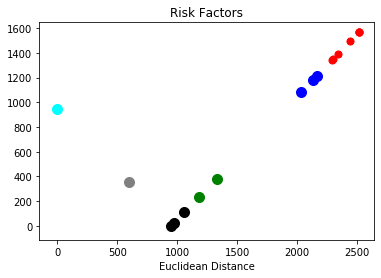

In [50]:
#plotting scatter plot in 2D

plt.scatter(v[clusters==0, 0], v[clusters==0, 1], s=50, c='red', label ='Cluster 1')
plt.scatter(v[clusters==1, 0], v[clusters==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(v[clusters==2, 0], v[clusters==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(v[clusters==3, 0], v[clusters==3, 1], s=100, c='cyan', label ='Cluster 4')
plt.scatter(v[clusters==4, 0], v[clusters==4, 1], s=100, c='grey', label ='Cluster 5')
plt.scatter(v[clusters==5, 0], v[clusters==5, 1], s=100, c='black', label ='Cluster 6')
plt.title('Risk Factors')
plt.xlabel('Euclidean Distance')
#plt.ylabel('')
plt.show()

## (4) DERIVING INSIGHTS FROM MODEL'S RESULTS________________________________________________

From the all four models that I have implemented, I get best results with **Hierarchical Clustering with tf using centroid method.**

### Insights from the final result. 

The clusters, we are getting from Hierarchical clustering(tf - centroid method), are covering a very wide area of each type of risk factor.
Let's try to get insights from each cluster. I am taking clusters based on its ascending order of risk level. 

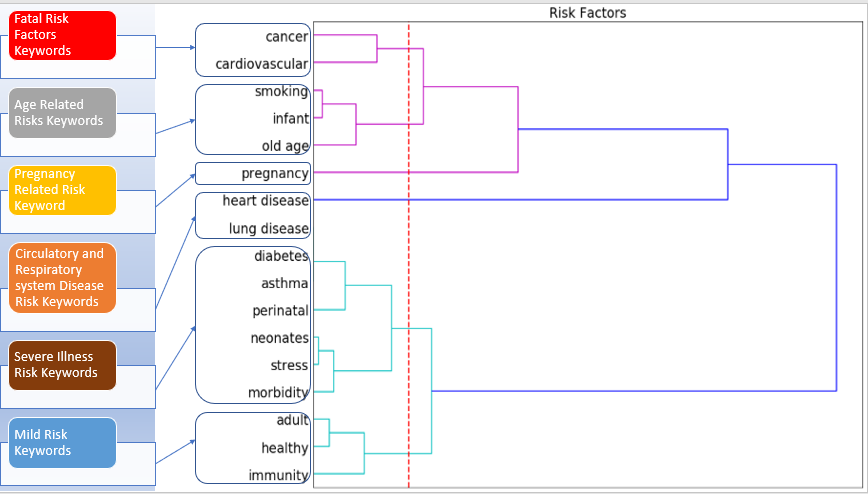

**1) "Mild Risk Keywords" cluster [Adult, Healthy, Immunity]**
- Adults have high immunity and they are healthier compared to infants and old age people. The chance of converting COVID19 case into fatality with adults is a very less considering they are not suffering from morbidity. Actual data is also complying with our analysis. As we can see that adults have hardly 0.2% chance of death rate/fatality rate. As they have high immune power.

**2) "Age Related Risks Keywords" cluster [Smoking, infant and old age]**
- The immunity system in infants is of a mother's immunity system, they have not started developing their own immunity system. Most of the old age people are suffering from at least one disease. Their immune power is also very low. They are at higher risk of developing more serious complications from COVID19. Their situation may convert into fatality if proper precautions are not taken. With age stress also increases due to work and responsibilities and this encourages most of the adults to start smoking. Smoking causes injury to lungs and as per the report death rate in "MEN" are high compared to "WOMEN" as smoking is much more prevalent in males. SO we can consider smoking as gender and age related addiction. As we can see that 80+ people have the highest death rate following 70-79%. 

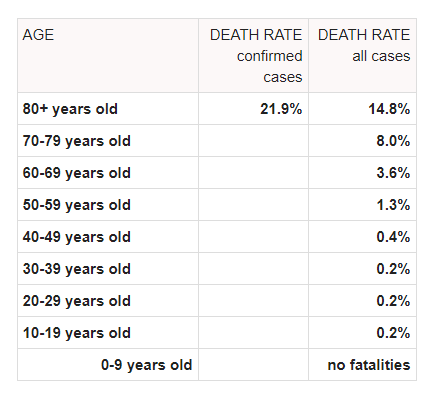

**3) "Pregnancy Related Risk Keyword" cluster [Pregnancy]**
- There is currently no evidence that suggests pregnant women are at a higher risk of becoming seriously ill from COVID-19. There is currently no evidence that a developing child could be negatively affected by COVID-19 but during pregnancy, women experience changes in their bodies that may increase the risk of other illnesses, such as viral respiratory infections. This is why it is important for pregnant women, especially those at high risk of developing severe complications should need to take precautions. 

Actual statistics show that Females have a lower death rate compared to males.
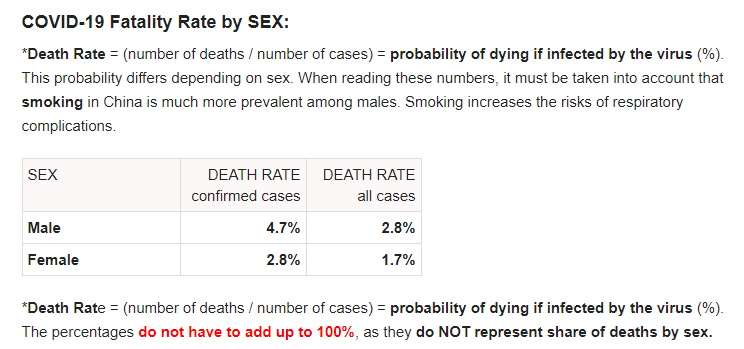


**4) "Severe Illness Risk Keywords" cluster [Diabetes, Asthma, Perinatal, Neonates, Stress/hypertension, Morbidity]**
- Covid19 can cause severe illness and complications in some people with diabetes condition. Covid19 can affect nose, lungs, throats (respiratory tract) and cause asthma attack. In some patients, it has caused pneumonia and acute respiratory disease. During perinatal period mothers have a higher risk of severe illness when infected with viruse COVID-19 and other viral respiratory infections, such as influenza as they are facing so many changes in their body. Mother-to-child transmission of coronavirus during pregnancy is unlikely, but after birth a newborn/neonates are susceptible to person-to-person spread. Though a very small number of babies tested positive with COVID19. Doctors are still trying to find whether these babies got before birth or after birth. Patients who are suffering from stress/depression,they are prone to severe illness. So all these risk factors may cause severe complications if the patient is affected by COVID19. 


**5) "Circulatory and Respiratory system Disease Risk Keywords" cluster [Heart disease and lung disease]**
- Patients who have already been suffered by heart attack may suffer inflammation of the heart muscle, called myocarditis. The heart muscle becomes weak and may develop dangerous heart rhythms which could turn into a fatality. About 10% of patients with pre-existing heart disease, who have been infected with COVID-19 will die, compared with only 1% of patients who are otherwise healthy. People with lung disease are most at developing severe complications as their respiratory health is already been compromised.  So this cluster depicts us the circulatory(heart) and respiratory(lung) disease related risk factors. 

**6) "Fatal Risk Factors Keywords" cluster [Cancer and cardiovascular]**
- As we can see that from the below image of the death rate of pre existing conditions, patients with cardiovascular disease have a high death rate followed by diabetes and lung disease. Patients with cardiovascular have 13.2% death rate whereas patients with cancer have 7.6% death rate. So we can say that this cluster represents Fatal risk factors. 


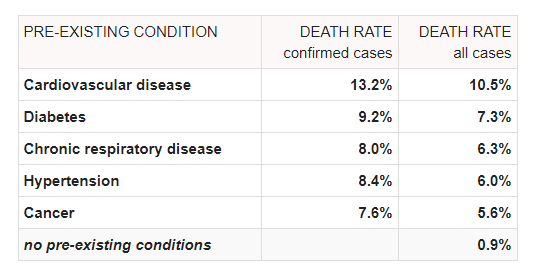

**CONCLUSION**
- Implementation of unsupervised machine learning helps us to get some insights from a large number of research papers. Findings from the models are also complying with real statistics related to COVID19 data. Classification of the clusters based on their keywords can be helpful to learn the pattern of mild, severe and fatal risk factors.  


#### References : 
- https://www.cdc.gov/
- https://www.canada.ca/en/public-health/services/publications/diseases-conditions
- https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/
- https://www.health.harvard.edu/blog/how-does-cardiovascular-disease-increase-the-risk-of-severe-illness-and-death-from-covid-19-2020040219401